# new_ltpp - Getting Started Guide

This notebook presents the main features of the **new_ltpp** (Easy Temporal Point Processes) library with practical examples.

## 🎯 Notebook Objectives

- Understand the basic concepts of temporal point processes
- Learn to configure and train models
- Explore the different types of data and available models
- Visualize and analyze results

## 📚 Table of Contents

1. [Environment Setup](#1-configuration)
2. [Basic Concepts](#2-concepts)
3. [Data Loading and Preparation](#3-data-loading-and-preparation)
4. [Model Configuration and Training](#4-model-configuration-and-training)
5. [Evaluation and Metrics](#5-evaluation-and-metrics)
6. [Distribution analysis](#6-advanced-examples)

## 1. Environment Setup {#1-configuration}

Let's start by importing the necessary modules and setting up the environment.

In [1]:
from pathlib import Path

# Add the project root directory to PYTHONPATH
ROOT = Path().absolute().parent

CONFIGS = ROOT / "yaml_configs" / "configs.yaml"

# new_ltpp imports (use the new builders and runner manager)
from new_ltpp.configs.config_builder import RunnerConfigBuilder, DataConfigBuilder
from new_ltpp.runners import RunnerManager
from new_ltpp.configs.config_factory import config_factory, ConfigType

print("✅ new_ltpp imported successfully!")
print(f"📁 Project directory: {ROOT}")

✅ new_ltpp imported successfully!
📁 Project directory: c:\Users\enzo.cAo\Documents\Projects\finance\projet_recherche\New_LTPP


## 2. Basic Concepts {#2-concepts}

### What is a Temporal Point Process?

A **Temporal Point Process** (TPP) is a sequence of events that occur over time. Each event is characterized by:

- **Occurrence time**: When the event happens
- **Event type**: What category of event (optional)

### Application examples:

- 🏥 **Medical**: Patient arrivals at a hospital
- 💰 **Finance**: Stock market transactions
- 🌍 **Geophysics**: Earthquakes
- 📱 **Social Networks**: User posts

### Models available in new_ltpp:

- **NHP** (Neural Hawkes Process): Hawkes processes with neural networks
- **THP** (Transformer Hawkes Process): Based on Transformer architecture
- **RMTPP** (Recurrent Marked Temporal Point Process): Based on RNNs
- **AttNHP** (Attentive Neural Hawkes Process): With attention mechanism

## 3. Data Loading and Preparation {#3-donnees}

new_ltpp supports multiple data formats. Let's see how to load and prepare data.

In [2]:
from new_ltpp.data.preprocess import TPPDataModule

In [3]:
builder = DataConfigBuilder()
builder.set_dataset_id("test")
builder.set_src_dir("NzoCs/test_dataset")

# Configure basic data loading parameters
builder.set_batch_size(32)
builder.set_num_workers(2)
builder.set_shuffle(True)

# Tokenizer specs
builder.set_num_event_types(2)
builder.set_max_len(128)

data_config = builder.build()

print("📦 Generated data configuration:")
print(data_config)


2025-10-04 02:24:58,479 - config_factory.py[pid:13124;line:94:create_config] - INFO: Création de la configuration: DataConfig
📦 Generated data configuration:
DataConfig({'train_dir': 'NzoCs/test_dataset', 'valid_dir': 'NzoCs/test_dataset', 'test_dir': 'NzoCs/test_dataset', 'data_format': 'NzoCs/test_dataset', 'dataset_id': 'test', 'data_loading_specs': {'batch_size': 32, 'tensor_type': 'pt', 'num_workers': 2, 'shuffle': True, 'padding': None, 'truncation': None, 'max_len': None}, 'tokenizer_specs': {'num_event_types': 2, 'pad_token_id': 2, 'padding_side': 'left', 'truncation_side': 'left', 'padding_strategy': 'longest', 'truncation_strategy': None, 'max_len': 128}})


In [4]:
# Create data module
datamodule = TPPDataModule(data_config)
datamodule.setup(stage='fit')  # Setup for training and validation

# Get data loaders
train_loader = datamodule.train_dataloader()
val_loader = datamodule.val_dataloader()

print("✅ Data loaders created successfully!")
print(f"   📈 Train loader: {len(train_loader)} batches")
print(f"   📊 Validation loader: {len(val_loader)} batches")

2025-10-04 02:24:58,527 - data_loader.py[pid:13124;line:140:setup] - INFO: Setting up data for stage: fit


c:\Users\enzo.cAo\Documents\Projects\finance\projet_recherche\New_LTPP\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2025-10-04 02:25:19,490 - data_loader.py[pid:13124;line:149:setup] - INFO: Train dataset created with 6 sequences
2025-10-04 02:25:32,233 - data_loader.py[pid:13124;line:158:setup] - INFO: Validation dataset created with 2 sequences
✅ Data loaders created successfully!
   📈 Train loader: 1 batches
   📊 Validation loader: 1 batches


### Data Inspection

Let's use the Visualizer to analyze the data distribution.

Generating visualization plots...
Metadata saved to ./analysis_plots\inter_event_time_dist.json
Inter-event time distribution plot saved to ./analysis_plots\inter_event_time_dist.png
Metadata saved to ./analysis_plots\inter_event_time_dist.json
Inter-event time distribution plot saved to ./analysis_plots\inter_event_time_dist.png


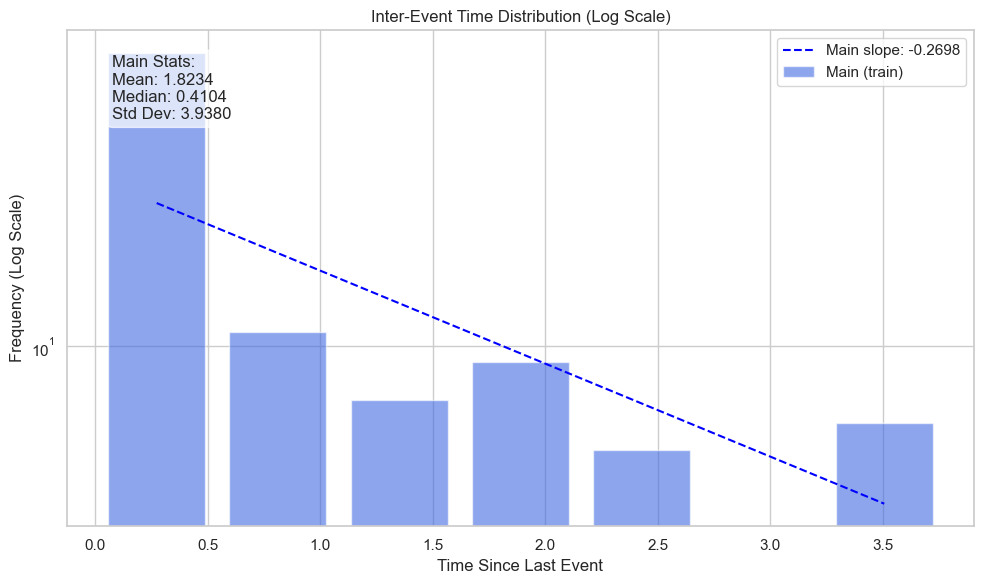

Metadata saved to ./analysis_plots\event_type_dist.json
Event type distribution plot saved to ./analysis_plots\event_type_dist.png


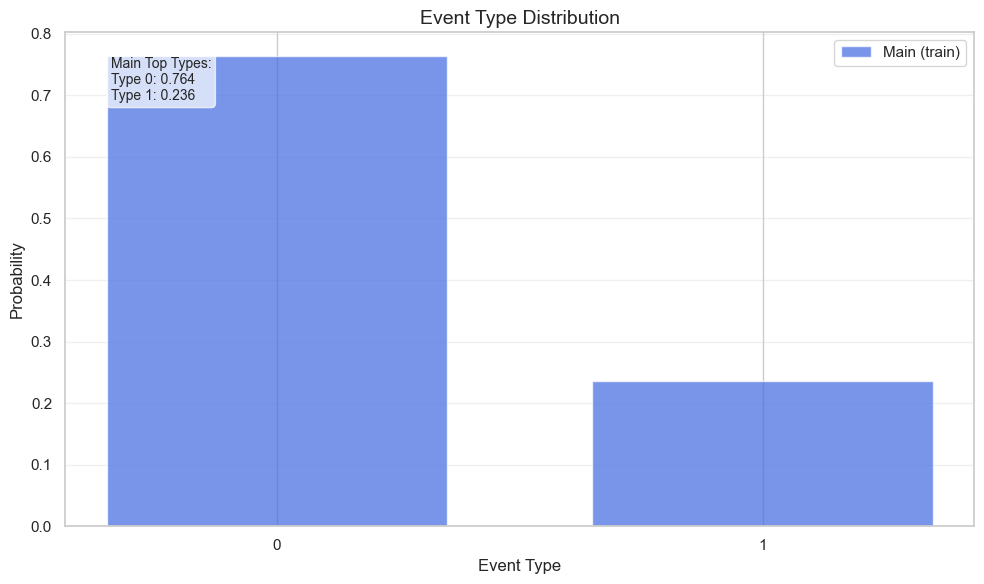

Metadata saved to ./analysis_plots\sequence_length_dist.json
Sequence length distribution plot saved to ./analysis_plots\sequence_length_dist.png


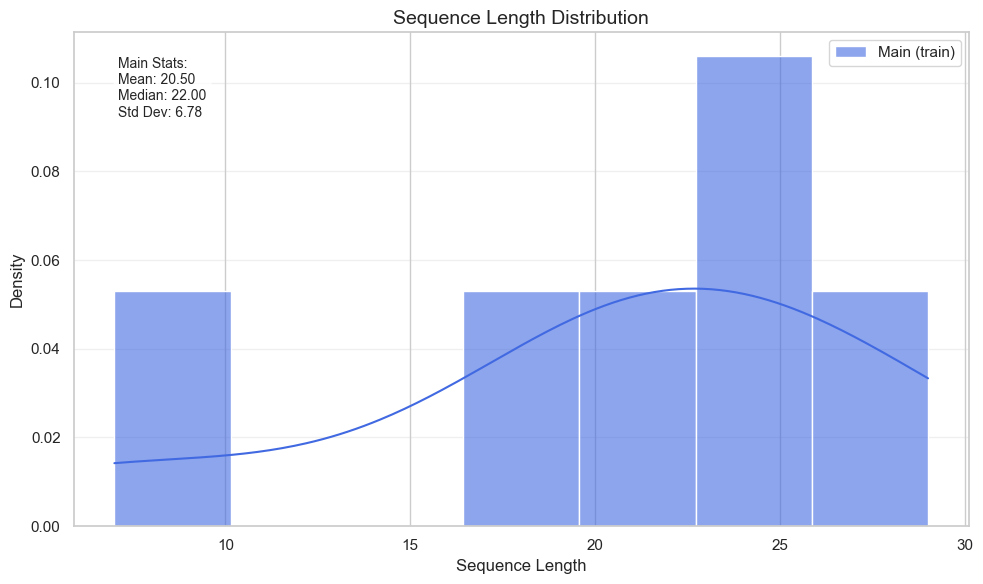

All plots generated successfully!
Metadata saved to ./analysis_plots\inter_event_time_dist.json
Inter-event time distribution plot saved to ./analysis_plots\inter_event_time_dist.png
Metadata saved to ./analysis_plots\inter_event_time_dist.json
Inter-event time distribution plot saved to ./analysis_plots\inter_event_time_dist.png


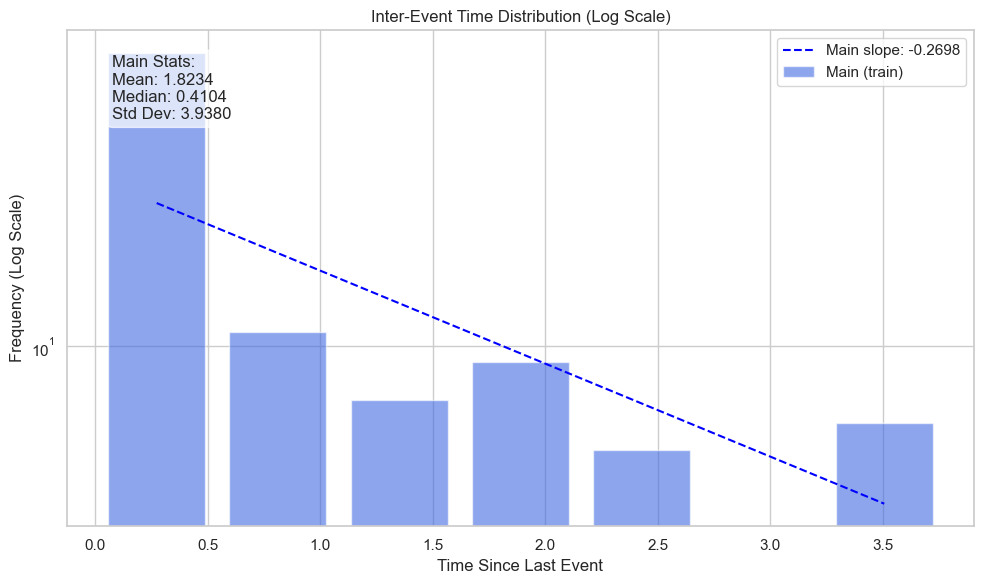

Metadata saved to ./analysis_plots\event_type_dist.json
Event type distribution plot saved to ./analysis_plots\event_type_dist.png


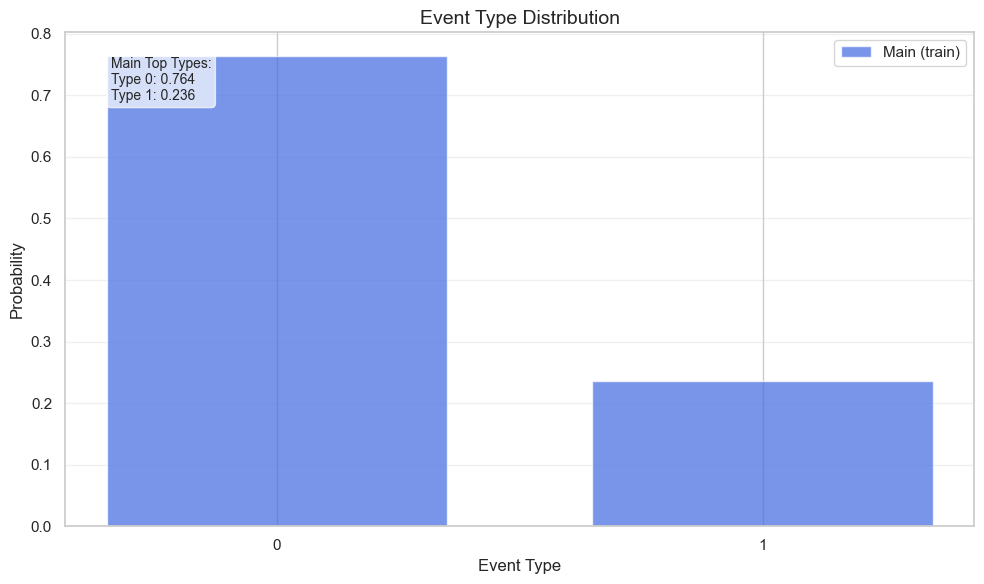

📈 Analysis plots generated!
   Check the './analysis_plots' folder for saved graphs


In [5]:
from new_ltpp.data.preprocess.visualizer import Visualizer

# Create the visualizer
visualizer = Visualizer(
    data_module=datamodule,
    split="train",
    save_dir="./analysis_plots"
)

# Generate visualizations
visualizer.show_all_distributions(show_graph=True)
visualizer.delta_times_distribution(show_graph=True)
visualizer.event_type_distribution(show_graph=True)

print("📈 Analysis plots generated!")
print("   Check the './analysis_plots' folder for saved graphs")

## 4. Model Configuration and Training {#4-entrainement}

Now, let's configure and train a Neural Hawkes Process (NHP) model.

In [6]:
# Build runner configuration from YAML using RunnerConfigBuilder
runner_builder = RunnerConfigBuilder()
runner_builder.load_from_yaml(
    yaml_file_path=str(CONFIGS),
    training_config_path="training_configs.quick_test",
    model_config_path="model_configs.neural_small",
    data_loading_config_path="data_loading_configs.quick_test",
    thinning_config_path="thinning_configs.thinning_fast",
    logger_config_path="logger_configs.csv",
    simulation_config_path="simulation_configs.simulation_fast",
    data_config_path="data_configs.test",
)

runner_config = runner_builder.build(model_id="NHP")

print("⚙️ Runner configuration built via factory + builder")
print(f"   🧠 Model: NHP")
print(f"   📊 Dataset: test")

2025-10-04 02:27:55,699 - config_factory.py[pid:13124;line:94:create_config] - INFO: Création de la configuration: RunnerConfig
⚙️ Runner configuration built via factory + builder
   🧠 Model: NHP
   📊 Dataset: test
⚙️ Runner configuration built via factory + builder
   🧠 Model: NHP
   📊 Dataset: test


In [8]:
# Alternative: Build runner config programmatically using set_* methods (no YAML loading)
print("⚙️ Building runner config programmatically without YAML...")

# Create a new RunnerConfigBuilder instance
programmatic_builder = RunnerConfigBuilder()

# Build data config using the data_builder attribute
programmatic_builder.data_builder.set_num_event_types(2)
programmatic_builder.data_builder.set_dataset_id("test")
programmatic_builder.data_builder.set_src_dir("NzoCs/test_dataset")
programmatic_builder.data_builder.set_batch_size(64)
programmatic_builder.data_builder.set_num_workers(2)
programmatic_builder.data_builder.set_shuffle(True)
programmatic_builder.data_builder.set_max_len(128)

# Build and set data config
data_config = programmatic_builder.data_builder.build()
programmatic_builder.set_data_config(data_config)

# Build model config using the model_builder attribute
programmatic_builder.model_builder.set_specs({"hidden_size": 32, "mlp_dims": [32, 32]})

# Set scheduler config with explicit parameters
programmatic_builder.model_builder.set_scheduler_config(
    max_epochs=50,
    lr_scheduler=True,
    lr=1e-3
)

# Set simulation config with explicit parameters
programmatic_builder.model_builder.set_simulation_config(
    start_time=20,
    end_time=50,
    batch_size=16,
    max_sim_events=5000,
    seed=42
)

# Set thinning config with explicit parameters
programmatic_builder.model_builder.set_thinning_config(
    num_sample=15,
    num_exp=50,
    use_mc_samples=True,
    loss_integral_num_sample_per_step=10,
    num_steps=10,
    over_sample_rate=1.2,
    num_samples_boundary=5,
    dtime_max=3.0
)

# Build and set model config
model_config = programmatic_builder.model_builder.build()
programmatic_builder.set_model_config(model_config)

# Set training config using convenience methods
programmatic_builder.set_max_epochs(50)
programmatic_builder.set_batch_size(64)
programmatic_builder.set_lr(1e-3)
programmatic_builder.set_lr_scheduler(True)
programmatic_builder.set_val_freq(1)
programmatic_builder.set_patience(3)
programmatic_builder.set_accumulate_grad_batches(1)
programmatic_builder.set_devices(1)

# Set runner-specific parameters
programmatic_builder.set_save_dir("./custom_output")

# Build the final config
custom_runner_config = programmatic_builder.build(model_id="NHP")

print("✅ Programmatic runner config built successfully!")
print(f"   🧠 Model: NHP")
print(f"   📊 Dataset: test")
print(f"   🔢 Max Epochs: {custom_runner_config.training_config.max_epochs}")
print(f"   📦 Batch Size: {custom_runner_config.training_config.batch_size}")
print(f"   💾 Save Dir: {custom_runner_config.save_dir}")


⚙️ Building runner config programmatically without YAML...
2025-10-04 02:28:22,426 - config_factory.py[pid:13124;line:94:create_config] - INFO: Création de la configuration: DataConfig
2025-10-04 02:28:22,429 - config_factory.py[pid:13124;line:94:create_config] - INFO: Création de la configuration: ModelConfig
2025-10-04 02:28:22,431 - config_factory.py[pid:13124;line:94:create_config] - INFO: Création de la configuration: RunnerConfig
✅ Programmatic runner config built successfully!
   🧠 Model: NHP
   📊 Dataset: test
   🔢 Max Epochs: 50
   📦 Batch Size: 64
   💾 Save Dir: C:\Users\enzo.cAo\Documents\Projects\finance\projet_recherche\New_LTPP\artifacts\custom_output
2025-10-04 02:28:22,429 - config_factory.py[pid:13124;line:94:create_config] - INFO: Création de la configuration: ModelConfig
2025-10-04 02:28:22,431 - config_factory.py[pid:13124;line:94:create_config] - INFO: Création de la configuration: RunnerConfig
✅ Programmatic runner config built successfully!
   🧠 Model: NHP
   📊 D

In [ ]:
# Create runner manager and start training
runner = RunnerManager(config=custom_runner_config, output_dir="./training_results")

print("🚀 Starting training...")
print("   This may take a few minutes depending on your configuration.")

# Train the model
runner.run(phase="train")

print("✅ Training completed!")

2025-10-04 02:29:24,217 - runner.py[pid:13124;line:32:__init__] - CRITICAL: Runner initialized for model: NHP on dataset: test
🚀 Starting training...
   This may take a few minutes depending on your configuration.
2025-10-04 02:29:24,220 - runner.py[pid:13124;line:97:run] - INFO: Runner executing phases: ['train']
2025-10-04 02:29:24,222 - runner.py[pid:13124;line:55:train] - INFO: === TRAINING PHASE ===
2025-10-04 02:29:24,224 - model_factory.py[pid:13124;line:42:create_model_by_name] - INFO: Création du modèle: NHP
🚀 Starting training...
   This may take a few minutes depending on your configuration.
2025-10-04 02:29:24,220 - runner.py[pid:13124;line:97:run] - INFO: Runner executing phases: ['train']
2025-10-04 02:29:24,222 - runner.py[pid:13124;line:55:train] - INFO: === TRAINING PHASE ===
2025-10-04 02:29:24,224 - model_factory.py[pid:13124;line:42:create_model_by_name] - INFO: Création du modèle: NHP
2025-10-04 02:29:24,232 - model_runner.py[pid:13124;line:108:__init__] - INFO: Ch

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-10-04 02:29:24,304 - data_loader.py[pid:13124;line:140:setup] - INFO: Setting up data for stage: fit
2025-10-04 02:29:29,994 - data_loader.py[pid:13124;line:149:setup] - INFO: Train dataset created with 6 sequences
2025-10-04 02:29:29,994 - data_loader.py[pid:13124;line:149:setup] - INFO: Train dataset created with 6 sequences
2025-10-04 02:29:34,480 - data_loader.py[pid:13124;line:158:setup] - INFO: Validation dataset created with 2 sequences
2025-10-04 02:29:34,480 - data_loader.py[pid:13124;line:158:setup] - INFO: Validation dataset created with 2 sequences


c:\Users\enzo.cAo\Documents\Projects\finance\projet_recherche\New_LTPP\.venv\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:751: Checkpoint directory C:\Users\enzo.cAo\Documents\Projects\finance\projet_recherche\New_LTPP\notebooks\training_results exists and is not empty.
Restoring states from the checkpoint path at ./training_results\best.ckpt

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | layer_type_emb  | Embedding        | 384    | train
1 | rnn_cell        | ContTimeLSTMCell | 230 K  | train
2 | layer_intensity | Sequential       | 260    | train
-------------------------------------------------------------
230 K     Trainable params
0         Non-trainable params
230 K     Total params
0.924     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode

  | Name            | Type             | Params | Mode 
-----------------------------------

c:\Users\enzo.cAo\Documents\Projects\finance\projet_recherche\New_LTPP\.venv\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 5: 100%|██████████| 1/1 [00:35<00:00,  0.03it/s, v_num=0, val_loss=2.300, train_loss=1.950]

Metric val_loss improved by 0.078 >= min_delta = 0.0. New best score: 2.301


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s, v_num=0, val_loss=2.240, train_loss=1.880]

Metric val_loss improved by 0.061 >= min_delta = 0.0. New best score: 2.240


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s, v_num=0, val_loss=2.190, train_loss=1.820]

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 2.194


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s, v_num=0, val_loss=2.160, train_loss=1.770]

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 2.161


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s, v_num=0, val_loss=2.140, train_loss=1.730]

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 2.137


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, v_num=0, val_loss=2.120, train_loss=1.690]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 2.122


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s, v_num=0, val_loss=2.110, train_loss=1.660]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 2.110


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s, v_num=0, val_loss=2.100, train_loss=1.630]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 2.099


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  1.87it/s, v_num=0, val_loss=2.090, train_loss=1.610]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 2.087


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s, v_num=0, val_loss=2.070, train_loss=1.590]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 2.073


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s, v_num=0, val_loss=2.060, train_loss=1.570]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 2.057


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s, v_num=0, val_loss=2.040, train_loss=1.560]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 2.039

Detected KeyboardInterrupt, attempting graceful shutdown ...

Detected KeyboardInterrupt, attempting graceful shutdown ...


SystemExit: 1

c:\Users\enzo.cAo\Documents\Projects\finance\projet_recherche\New_LTPP\.venv\Lib\site-packages\IPython\core\interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## 5. Evaluation and Metrics {#5-evaluation}

Let's now evaluate the performance of the trained model.

In [8]:
# Evaluation on test dataset
print("🧪 Evaluating model on test dataset...")

test_results = runner.run(phase="test")

print("📊 Evaluation results:")
if hasattr(runner, 'test_metrics'):
    for metric_name, value in runner.test_metrics.items():
        print(f"   {metric_name}: {value:.4f}")
else:
    print("✅ Evaluation completed - check logs for detailed metrics")

🧪 Evaluating model on test dataset...
2025-10-03 22:27:30,584 - runner.py[pid:504;line:97:run] - INFO: Runner executing phases: ['test']
2025-10-03 22:27:30,585 - runner.py[pid:504;line:61:test] - CRITICAL: === TESTING PHASE ===
2025-10-03 22:27:30,587 - model_runner.py[pid:504;line:275:test] - INFO: --- Starting Testing for Model : NHP on dataset : test ---
2025-10-03 22:27:30,588 - data_loader.py[pid:504;line:140:setup] - INFO: Setting up data for stage: test


Restoring states from the checkpoint path at C:\Users\enzo.cAo\Documents\Projects\finance\projet_recherche\New_LTPP\artifacts\checkpoints\NHP\test\saved_model\best.ckpt
Loaded model weights from the checkpoint at C:\Users\enzo.cAo\Documents\Projects\finance\projet_recherche\New_LTPP\artifacts\checkpoints\NHP\test\saved_model\best.ckpt
c:\Users\enzo.cAo\Documents\Projects\finance\projet_recherche\New_LTPP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.79it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       cross_entropy       │    0.49844682216644287    │
│       macro_f1score       │     81.37931060791016     │
│         precision         │     81.37931060791016     │
│          recall           │     81.37931060791016     │
│         test_loss         │    1.8649168014526367     │
│         time_mae          │    1.8242831230163574     │
│         time_rmse         │     2.947070837020874     │
│       type_accuracy       │     81.48148345947266     │
└───────────────────────────┴───────────────────────────┘

2025-10-03 22:27:47,332 - model_runner.py[pid:504;line:299:test] - INFO: Test results saved to C:\Users\enzo.cAo\Documents\Projects\finance\projet_recherche\New_LTPP\artifacts\checkpoints\NHP\test\saved_model\test_results.json
📊 Evaluation results:
✅ Evaluation completed - check logs for detailed metrics


### Comparison with Baselines

Let's compare our model with simple baselines.

In [9]:
from new_ltpp.evaluation.benchmarks.mean_bench import MeanInterTimeBenchmark
from new_ltpp.evaluation.benchmarks.sample_distrib_mark_bench import MarkDistributionBenchmark

# Baseline benchmark: mean prediction
mean_benchmark = MeanInterTimeBenchmark(
    data_config=data_config,
    save_dir="./benchmark_results"
)

print("📊 Baseline benchmark (mean):")
mean_results = mean_benchmark.evaluate()
print(f"   Results: {mean_results}")

# Type distribution benchmark
mark_benchmark = MarkDistributionBenchmark(
    data_config=data_config,
    save_dir="./benchmark_results"
)

print("\n📊 Type distribution benchmark:")
mark_results = mark_benchmark.evaluate()
print(f"   Results: {mark_results}")

2025-10-03 22:27:51,223 - data_loader.py[pid:504;line:140:setup] - INFO: Setting up data for stage: test
📊 Baseline benchmark (mean):
2025-10-03 22:27:56,182 - base_bench.py[pid:504;line:146:evaluate] - INFO: Starting mean_inter_time benchmark evaluation...
2025-10-03 22:27:56,183 - mean_bench.py[pid:504;line:52:_prepare_benchmark] - INFO: Computing mean inter-time from training data...
2025-10-03 22:28:05,228 - mean_bench.py[pid:504;line:75:_prepare_benchmark] - INFO: Computed mean inter-time: 1.506245
2025-10-03 22:28:16,715 - base_bench.py[pid:504;line:364:_save_results] - INFO: Results saved to: ./benchmark_results\test\mean_inter_time_results.json
2025-10-03 22:28:16,716 - base_bench.py[pid:504;line:373:_log_summary] - INFO: mean_inter_time benchmark completed successfully!
2025-10-03 22:28:16,716 - base_bench.py[pid:504;line:379:_log_summary] - INFO: Time RMSE: 2.772637
2025-10-03 22:28:16,718 - base_bench.py[pid:504;line:381:_log_summary] - INFO: Time MAE: 1.840395
   Results: {

## 6. Advanced Examples {#6-avances}

### Synthetic Data Generation

new_ltpp allows generating synthetic data to test models.

In [10]:
from new_ltpp.data.generation import HawkesSimulator

# Hawkes process configuration
params = {
    "mu": [0.1, 0.2],                    # Base intensities
    "alpha": [[0.3, 0.1], [0.2, 0.4]],  # Excitation matrix
    "beta": [[2, 1], [1.5, 3]]          # Decay matrix
}

# Create simulator
simulator = HawkesSimulator(
    mu=params["mu"],
    alpha=params["alpha"],
    beta=params["beta"],
    dim_process=2,
    start_time=0,
    end_time=100
)

print("🎲 Generating synthetic data...")

# Generate and save
simulator.generate_and_save(
    output_dir='./synthetic_data',
    num_simulations=10,
    splits={'train': 0.6, 'test': 0.2, 'dev': 0.2}
)

print("✅ Synthetic data generated in './synthetic_data'")

🎲 Generating synthetic data...
Génération de 10 simulations 2D...


Simulation de 10 processus: 100%|██████████| 10/10 [00:00<00:00, 51.38it/s]


Division des données en ensembles train/test/dev...
Sauvegarde des données...
Toutes les données ont été sauvegardées dans ./synthetic_data
✅ Synthetic data generated in './synthetic_data'


## 6. Prediction Phase and Distribution Analysis

**Why the prediction phase is crucial:**

Temporal Point Process (TPP) models don't just serve to calculate performance metrics - their true value lies in their ability to **predict and simulate** new events. These predictions enable:

1. **Distribution comparisons** - Analyze whether the model captures temporal patterns well
2. **Realistic benchmarks** - Compare model simulations to real data  
3. **Qualitative validation** - Visualize differences between predictions and reality
4. **Practical applications** - Generate future scenarios for decision-making

### 6.1 Complete Pipeline with Predictions

In [12]:
# Complete example: train → test → predict using RunnerConfigBuilder and RunnerManager
print("🔄 Complete pipeline with predictions...")

print("🔮 Generating predictions and distribution comparisons...")
runner.run(phase="predict")

print("✅ Complete pipeline finished!")
print("📊 Results available in:")
print("   - Performance metrics")
print("   - Model simulations") 
print("   - Distribution comparisons")
print("   - Analysis graphs")

🔄 Complete pipeline with predictions...
🔮 Generating predictions and distribution comparisons...
2025-10-03 22:30:00,294 - runner.py[pid:504;line:97:run] - INFO: Runner executing phases: ['predict']
2025-10-03 22:30:00,297 - runner.py[pid:504;line:67:predict] - CRITICAL: === PREDICTION PHASE ===
2025-10-03 22:30:00,298 - model_runner.py[pid:504;line:305:predict] - INFO: --- Starting Prediction for Model : NHP on dataset : test ---
2025-10-03 22:30:00,300 - data_loader.py[pid:504;line:140:setup] - INFO: Setting up data for stage: predict
2025-10-03 22:30:00,297 - runner.py[pid:504;line:67:predict] - CRITICAL: === PREDICTION PHASE ===
2025-10-03 22:30:00,298 - model_runner.py[pid:504;line:305:predict] - INFO: --- Starting Prediction for Model : NHP on dataset : test ---
2025-10-03 22:30:00,300 - data_loader.py[pid:504;line:140:setup] - INFO: Setting up data for stage: predict


Restoring states from the checkpoint path at C:\Users\enzo.cAo\Documents\Projects\finance\projet_recherche\New_LTPP\artifacts\checkpoints\NHP\test\saved_model\best.ckpt
Loaded model weights from the checkpoint at C:\Users\enzo.cAo\Documents\Projects\finance\projet_recherche\New_LTPP\artifacts\checkpoints\NHP\test\saved_model\best.ckpt
Loaded model weights from the checkpoint at C:\Users\enzo.cAo\Documents\Projects\finance\projet_recherche\New_LTPP\artifacts\checkpoints\NHP\test\saved_model\best.ckpt
c:\Users\enzo.cAo\Documents\Projects\finance\projet_recherche\New_LTPP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\enzo.cAo\Documents\Projects\finance\projet_recherche\New_LTPP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

Simulation:   0%|          | 0/50 [00:00<?, ?it/s]

Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.48it/s]



Formatting sequences: 100%|██████████| 2/2 [00:00<00:00, 3120.76it/s]

Data successfully saved to C:\Users\enzo.cAo\Documents\Projects\finance\projet_recherche\New_LTPP\artifacts\checkpoints\NHP\test\distributions_comparisons\simulations.json
2025-10-03 22:30:18,738 - comparator.py[pid:504;line:142:create_comparator] - INFO: Using TPPDatasetExtractor for optimized data extraction
2025-10-03 22:30:18,739 - comparator.py[pid:504;line:69:run_comprehensive_evaluation] - INFO: Starting comprehensive temporal point process evaluation...
2025-10-03 22:30:18,739 - comparator.py[pid:504;line:69:run_comprehensive_evaluation] - INFO: Starting comprehensive temporal point process evaluation...
2025-10-03 22:30:18,741 - data_extractors.py[pid:504;line:71:_extract_all_data] - INFO: Extracting ground truth data from TPPDataset with 2 sequences...
2025-10-03 22:30:18,745 - data_extractors.py[pid:504;line:120:_extract_all_data] - INFO: Successfully processed 2/2 sequences, extracted 56 events
2025-10-03 22:30:18,748 - data_extractors.py[pid:504;line:279:_extract_all_data]

2025-10-03 22:30:19,342 - distribution_analyzer.py[pid:504;line:121:plot_density_comparison] - INFO: Density comparison plot successfully saved to C:\Users\enzo.cAo\Documents\Projects\finance\projet_recherche\New_LTPP\artifacts\checkpoints\NHP\test\distributions_comparisons\comparison_inter_event_time_dist.png
2025-10-03 22:30:19,777 - plot_generators.py[pid:504;line:168:generate_plot] - INFO: Event type distribution comparison plot saved to C:\Users\enzo.cAo\Documents\Projects\finance\projet_recherche\New_LTPP\artifacts\checkpoints\NHP\test\distributions_comparisons\comparison_event_type_dist.png
2025-10-03 22:30:19,777 - plot_generators.py[pid:504;line:168:generate_plot] - INFO: Event type distribution comparison plot saved to C:\Users\enzo.cAo\Documents\Projects\finance\projet_recherche\New_LTPP\artifacts\checkpoints\NHP\test\distributions_comparisons\comparison_event_type_dist.png
2025-10-03 22:30:20,290 - plot_generators.py[pid:504;line:260:generate_plot] - INFO: Sequence length d

### 6.2 Simplified Alternative: Single Command

If you want the complete pipeline all at once:

In [13]:
# Ultra-simple version: everything in one command
# Use RunnerManager (runner variable) already created above
runner.run(phase="all")

print("🎉 Complete pipeline executed with phase='all'!")
print("💡 This command is equivalent to the 3 separate phases above")

2025-10-03 22:39:34,629 - runner.py[pid:504;line:97:run] - INFO: Runner executing phases: ['train', 'test', 'predict']
2025-10-03 22:39:34,630 - runner.py[pid:504;line:55:train] - INFO: === TRAINING PHASE ===
2025-10-03 22:39:34,632 - model_runner.py[pid:504;line:251:train] - INFO: --- Starting Training for Model : NHP on dataset : test ---
2025-10-03 22:39:34,633 - data_loader.py[pid:504;line:140:setup] - INFO: Setting up data for stage: fit
2025-10-03 22:39:34,630 - runner.py[pid:504;line:55:train] - INFO: === TRAINING PHASE ===
2025-10-03 22:39:34,632 - model_runner.py[pid:504;line:251:train] - INFO: --- Starting Training for Model : NHP on dataset : test ---
2025-10-03 22:39:34,633 - data_loader.py[pid:504;line:140:setup] - INFO: Setting up data for stage: fit
2025-10-03 22:39:40,457 - data_loader.py[pid:504;line:149:setup] - INFO: Train dataset created with 6 sequences
2025-10-03 22:39:40,457 - data_loader.py[pid:504;line:149:setup] - INFO: Train dataset created with 6 sequences
2

c:\Users\enzo.cAo\Documents\Projects\finance\projet_recherche\New_LTPP\.venv\Lib\site-packages\lightning_fabric\loggers\csv_logs.py:268: Experiment logs directory C:\Users\enzo.cAo\Documents\Projects\finance\projet_recherche\New_LTPP\artifacts\checkpoints\NHP\test\csv_logs\version_1 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
c:\Users\enzo.cAo\Documents\Projects\finance\projet_recherche\New_LTPP\.venv\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:751: Checkpoint directory C:\Users\enzo.cAo\Documents\Projects\finance\projet_recherche\New_LTPP\artifacts\checkpoints\NHP\test\saved_model exists and is not empty.
Restoring states from the checkpoint path at C:\Users\enzo.cAo\Documents\Projects\finance\projet_recherche\New_LTPP\artifacts\checkpoints\NHP\test\saved_model\best.ckpt

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | layer_typ

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\enzo.cAo\Documents\Projects\finance\projet_recherche\New_LTPP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


c:\Users\enzo.cAo\Documents\Projects\finance\projet_recherche\New_LTPP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\enzo.cAo\Documents\Projects\finance\projet_recherche\New_LTPP\.venv\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
`Trainer.fit` stopped: `max_epochs=5` reached.


2025-10-03 22:40:01,355 - runner.py[pid:504;line:61:test] - CRITICAL: === TESTING PHASE ===
2025-10-03 22:40:01,357 - model_runner.py[pid:504;line:275:test] - INFO: --- Starting Testing for Model : NHP on dataset : test ---
2025-10-03 22:40:01,359 - data_loader.py[pid:504;line:140:setup] - INFO: Setting up data for stage: test
2025-10-03 22:40:01,357 - model_runner.py[pid:504;line:275:test] - INFO: --- Starting Testing for Model : NHP on dataset : test ---
2025-10-03 22:40:01,359 - data_loader.py[pid:504;line:140:setup] - INFO: Setting up data for stage: test


Restoring states from the checkpoint path at C:\Users\enzo.cAo\Documents\Projects\finance\projet_recherche\New_LTPP\artifacts\checkpoints\NHP\test\saved_model\best.ckpt
Loaded model weights from the checkpoint at C:\Users\enzo.cAo\Documents\Projects\finance\projet_recherche\New_LTPP\artifacts\checkpoints\NHP\test\saved_model\best.ckpt
Loaded model weights from the checkpoint at C:\Users\enzo.cAo\Documents\Projects\finance\projet_recherche\New_LTPP\artifacts\checkpoints\NHP\test\saved_model\best.ckpt
c:\Users\enzo.cAo\Documents\Projects\finance\projet_recherche\New_LTPP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\enzo.cAo\Documents\Projects\finance\projet_recherche\New_LTPP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_co

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.42it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       cross_entropy       │    0.49844682216644287    │
│       macro_f1score       │     81.37931060791016     │
│         precision         │     81.37931060791016     │
│          recall           │     81.37931060791016     │
│         test_loss         │    1.8649168014526367     │
│         time_mae          │     1.731859803199768     │
│         time_rmse         │     2.850342273712158     │
│       type_accuracy       │     81.48148345947266     │
└───────────────────────────┴───────────────────────────┘

2025-10-03 22:40:17,068 - model_runner.py[pid:504;line:299:test] - INFO: Test results saved to C:\Users\enzo.cAo\Documents\Projects\finance\projet_recherche\New_LTPP\artifacts\checkpoints\NHP\test\saved_model\test_results.json
2025-10-03 22:40:17,070 - runner.py[pid:504;line:67:predict] - CRITICAL: === PREDICTION PHASE ===
2025-10-03 22:40:17,071 - model_runner.py[pid:504;line:305:predict] - INFO: --- Starting Prediction for Model : NHP on dataset : test ---
2025-10-03 22:40:17,072 - data_loader.py[pid:504;line:140:setup] - INFO: Setting up data for stage: predict
2025-10-03 22:40:17,070 - runner.py[pid:504;line:67:predict] - CRITICAL: === PREDICTION PHASE ===
2025-10-03 22:40:17,071 - model_runner.py[pid:504;line:305:predict] - INFO: --- Starting Prediction for Model : NHP on dataset : test ---
2025-10-03 22:40:17,072 - data_loader.py[pid:504;line:140:setup] - INFO: Setting up data for stage: predict


Restoring states from the checkpoint path at C:\Users\enzo.cAo\Documents\Projects\finance\projet_recherche\New_LTPP\artifacts\checkpoints\NHP\test\saved_model\best.ckpt
Loaded model weights from the checkpoint at C:\Users\enzo.cAo\Documents\Projects\finance\projet_recherche\New_LTPP\artifacts\checkpoints\NHP\test\saved_model\best.ckpt
Loaded model weights from the checkpoint at C:\Users\enzo.cAo\Documents\Projects\finance\projet_recherche\New_LTPP\artifacts\checkpoints\NHP\test\saved_model\best.ckpt
c:\Users\enzo.cAo\Documents\Projects\finance\projet_recherche\New_LTPP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\enzo.cAo\Documents\Projects\finance\projet_recherche\New_LTPP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

Simulation:   0%|          | 0/50 [00:00<?, ?it/s]

Predicting DataLoader 0: 100%|██████████| 1/1 [00:01<00:00,  0.68it/s]



Formatting sequences: 100%|██████████| 4/4 [00:00<00:00, 4452.55it/s]

Data successfully saved to C:\Users\enzo.cAo\Documents\Projects\finance\projet_recherche\New_LTPP\artifacts\checkpoints\NHP\test\distributions_comparisons\simulations.json
2025-10-03 22:40:34,443 - comparator.py[pid:504;line:142:create_comparator] - INFO: Using TPPDatasetExtractor for optimized data extraction
2025-10-03 22:40:34,444 - comparator.py[pid:504;line:69:run_comprehensive_evaluation] - INFO: Starting comprehensive temporal point process evaluation...
2025-10-03 22:40:34,444 - data_extractors.py[pid:504;line:71:_extract_all_data] - INFO: Extracting ground truth data from TPPDataset with 2 sequences...
2025-10-03 22:40:34,447 - data_extractors.py[pid:504;line:120:_extract_all_data] - INFO: Successfully processed 2/2 sequences, extracted 56 events
2025-10-03 22:40:34,448 - data_extractors.py[pid:504;line:279:_extract_all_data] - INFO: Processing simulation data...
2025-10-03 22:40:34,444 - comparator.py[pid:504;line:69:run_comprehensive_evaluation] - INFO: Starting comprehensiv

2025-10-03 22:40:35,069 - distribution_analyzer.py[pid:504;line:121:plot_density_comparison] - INFO: Density comparison plot successfully saved to C:\Users\enzo.cAo\Documents\Projects\finance\projet_recherche\New_LTPP\artifacts\checkpoints\NHP\test\distributions_comparisons\comparison_inter_event_time_dist.png
2025-10-03 22:40:35,510 - plot_generators.py[pid:504;line:168:generate_plot] - INFO: Event type distribution comparison plot saved to C:\Users\enzo.cAo\Documents\Projects\finance\projet_recherche\New_LTPP\artifacts\checkpoints\NHP\test\distributions_comparisons\comparison_event_type_dist.png
2025-10-03 22:40:35,510 - plot_generators.py[pid:504;line:168:generate_plot] - INFO: Event type distribution comparison plot saved to C:\Users\enzo.cAo\Documents\Projects\finance\projet_recherche\New_LTPP\artifacts\checkpoints\NHP\test\distributions_comparisons\comparison_event_type_dist.png
2025-10-03 22:40:35,922 - plot_generators.py[pid:504;line:260:generate_plot] - INFO: Sequence length d

**🎯 Main objective:** Verify that the model has learned the correct temporal distributions.

**📊 What the `predict` phase generates:**
- **Event simulations** based on the trained model
- **Visual comparisons** between real and simulated data
- **Statistical analyses** of temporal distributions
- **Prediction quality metrics**

**⚠️ Crucial point:** Without the prediction phase, you only have numerical metrics. With predictions, you can **see** if your model truly understands the temporal dynamics of your data.

In [1]:
import shutil
import os

folders_to_remove = [
    "analysis_plots",
    "training_results",
    "benchmark_results",
    "synthetic_data",
    "comparison_results",
    "prediction_analysis",
    "complete_pipeline",
    "checkpoints",
    "distributions_comparisons"
]

for folder in folders_to_remove:
    if os.path.exists(folder):
        shutil.rmtree(folder)
        print(f"Deleted: {folder}")
    else:
        print(f"Not found: {folder}")

Deleted: analysis_plots
Not found: training_results
Deleted: benchmark_results
Deleted: synthetic_data
Not found: comparison_results
Not found: prediction_analysis
Not found: complete_pipeline
Not found: checkpoints
Not found: distributions_comparisons
